In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

In [ ]:
# Load data
sellers_df = pd.read_csv('sellers.csv')
reviews_df = pd.read_csv('reviews.csv')
products_df = pd.read_csv('products.csv')
orders_df = pd.read_csv('orders.csv')
order_payments_df = pd.read_csv('order_payments.csv')
order_items_df = pd.read_csv('order_items.csv')
geolocalizaciones_df = pd.read_csv('geolocalizaciones.csv')
customers_df = pd.read_csv('customers.csv')

# Display first few rows of each dataframe
(sellers_df.head(), reviews_df.head(), products_df.head(), orders_df.head(), order_payments_df.head(), order_items_df.head(), geolocalizaciones_df.head(), customers_df.head())

(                          seller_id  postal_code
 0  1d4d325f6e9a8b3e2a34ba45c6fab13b      1248188
 1  251058403151a0d80eb4fee3e2ee408c      1238658
 2  851a7816c5034f490621cc8e2335b4c2      1240950
 3  85fe9bc9e765ea6599ee57efb7375802      1245530
 4  2ebd36cec0aa8bd78760114725fbdfa1      1248150,
                           review_id                          order_id score  \
 0  6dfcfbbaab5833310f5fdd05dc83d906  0a5dd6592278318157d87679d109f330     4   
 1  9d449255ff8c66ecca9cdde6e908ea82  3fa1e7d63588d1a74b82affa9b003e1e     5   
 2  a7200f24b7d755f39c8465d3ce49962a  cc9fa5ec8f08f922d1c7416d6b46018b     5   
 3  3adcf419637445b9a8a465732dd9edb6  719875e07cb5dff104ca3590bdcb9123     5   
 4  d4a80055586b443ec619012c6e30df7a  0da0db906205eb9d9d04e6111fa301cf     5   
 
    has_comment review_creation_date review_answer_timestamp  
 0            0  2023-01-18 01:00:00     2023-01-18 22:46:59  
 1            0  2023-03-10 01:00:00     2023-03-11 04:05:13  
 2            0  2023-02-17 

In [ ]:
# Inspect dataframes
def inspect_dataframe(df, name):
    print(f"DataFrame: {name}")
    print(df.info())
    print(f"Valores nulos:\n{df.isnull().sum()}\n")

inspect_dataframe(sellers_df, 'sellers')
inspect_dataframe(reviews_df, 'reviews')
inspect_dataframe(products_df, 'products')
inspect_dataframe(orders_df, 'orders')
inspect_dataframe(order_payments_df, 'order_payments')
inspect_dataframe(order_items_df, 'order_items')
inspect_dataframe(geolocalizaciones_df, 'geolocalizaciones')
inspect_dataframe(customers_df, 'customers')

DataFrame: sellers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   seller_id    3095 non-null   object
 1   postal_code  3095 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.5+ KB
None
Valores nulos:
seller_id      0
postal_code    0
dtype: int64

DataFrame: reviews
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   score                    99224 non-null  object
 3   has_comment              99224 non-null  int64 
 4   review_creation_date     99224 non-null  object
 5   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(5)
memory usage:

In [ ]:
# Handle missing values
products_df['category_name'].fillna('unknown', inplace=True)
products_df['weight_g'].fillna(products_df['weight_g'].median(), inplace=True)
products_df['length_cm'].fillna(products_df['length_cm'].median(), inplace=True)
products_df['height_cm'].fillna(products_df['height_cm'].median(), inplace=True)
products_df['width_cm'].fillna(products_df['width_cm'].median(), inplace=True)

default_date = pd.to_datetime('1970-01-01')
orders_df['approved_at'].fillna(default_date, inplace=True)
orders_df['delivered_courier_date'].fillna(default_date, inplace=True)
orders_df['delivered_customer_date'].fillna(default_date, inplace=True)

geolocalizaciones_df.dropna(subset=['CITY'], inplace=True)

# Transform data types
orders_df['purchase_timestamp'] = pd.to_datetime(orders_df['purchase_timestamp'])
orders_df['approved_at'] = pd.to_datetime(orders_df['approved_at'])
orders_df['delivered_courier_date'] = pd.to_datetime(orders_df['delivered_courier_date'])
orders_df['delivered_customer_date'] = pd.to_datetime(orders_df['delivered_customer_date'])
orders_df['estimated_delivery_date'] = pd.to_datetime(orders_df['estimated_delivery_date'])

order_items_df['shipping_limit_date'] = pd.to_datetime(order_items_df['shipping_limit_date'])

reviews_df['review_creation_date'] = pd.to_datetime(reviews_df['review_creation_date'])
reviews_df['review_answer_timestamp'] = pd.to_datetime(reviews_df['review_answer_timestamp'])

# Fix score values
reviews_df['score'] = reviews_df['score'].replace('s', 5).astype(int)

In [ ]:
# Merge dataframes
orders_items_merged = pd.merge(orders_df, order_items_df, on='order_id')
orders_items_products_merged = pd.merge(orders_items_merged, products_df, on='product_id')
orders_items_products_customers_merged = pd.merge(orders_items_products_merged, customers_df, on='customer_id')
final_merged = pd.merge(orders_items_products_customers_merged, reviews_df, on='order_id')
final_merged = pd.merge(final_merged, sellers_df, on='seller_id')

# Display first few rows of the final merged dataframe
final_merged.head()

,order_id,customer_id,status,purchase_timestamp,approved_at,delivered_courier_date,delivered_customer_date,estimated_delivery_date,product_id,seller_id,...,height_cm,width_cm,customer_unique_id,postal_code_x,review_id,score,has_comment,review_creation_date,review_answer_timestamp,postal_code_y
0,1582d3d1c7a4c1fd7b5857c7e6c084bb,c1d75069901ff3b203405a36de0c653b,delivered,2022-10-02 10:56:33,2022-10-02 11:07:15,2022-10-04 19:55:00,2022-10-10 21:25:13,2022-10-18,90999cd36d5663a2c6d47596f5691e5d,c81a68076c4073d5ce40aff52ebbabd7,...,8.0,13.0,317117b1f506acd43bf349062377969a,1244817,f451806b7c2d8eb76a0e1f6ff9b55c62,4,1,2022-10-11 02:00:00,2022-10-12 05:43:48,1247570
1,7c9a4eae39c94ad00616f311f5c818fe,575536c9ff832db6ffb06bf77a2db1f8,delivered,2022-08-15 18:29:31,2022-08-15 20:05:16,2022-08-17 15:28:33,2022-08-18 14:44:43,2022-08-28,90999cd36d5663a2c6d47596f5691e5d,c81a68076c4073d5ce40aff52ebbabd7,...,8.0,13.0,76642cc018b69d00ed372568d6c0f298,1244983,61875973922a1cafccbcdace184cecdd,4,1,2022-08-19 02:00:00,2022-08-20 17:16:36,1247570
2,8cc150ef5ca042c12f5100537a9ee222,ca53b326949e94be1f71ef58fe0adbb0,delivered,2022-08-02 18:24:47,2022-08-02 18:43:15,2022-08-04 17:35:43,2022-08-07 18:30:01,2022-08-15,90999cd36d5663a2c6d47596f5691e5d,c81a68076c4073d5ce40aff52ebbabd7,...,8.0,13.0,db969d79f0e326daa42ff0bc0a9b5116,1244340,25098e6957293b1bc887c830d6cbb286,5,1,2022-08-08 02:00:00,2022-08-09 01:26:23,1247570
3,1dc013d29f066a553fdfe8a0c2a502c2,b21fb813558c428976fa1aaecc396926,delivered,2022-10-23 23:26:46,2022-10-25 02:14:11,2022-10-27 16:48:46,2022-11-07 18:04:59,2022-11-13,90999cd36d5663a2c6d47596f5691e5d,c81a68076c4073d5ce40aff52ebbabd7,...,8.0,13.0,4bb31ef992deb86142fef7c0856fe221,1243296,0072540dfdfad480f77ea502c0bfb370,3,0,2022-11-08 01:00:00,2022-11-10 20:52:38,1247570
4,890251b5fed15cf9dacb545e91c18376,2f0fdafde6563a96e036b14bdf4dfc6b,delivered,2022-08-10 13:35:55,2022-08-10 13:50:09,2022-08-11 13:52:35,2022-08-16 19:03:36,2022-08-23,8b20985aa19f4942dd1e05451f28aea7,c81a68076c4073d5ce40aff52ebbabd7,...,10.0,15.0,a018ecad5cf2e2ee217bfb658e323d20,1247409,d713bebfd0524ceea7d14971c25f2041,5,1,2022-08-17 02:00:00,2022-08-21 14:43:27,1247570


                  purchase_timestamp                    approved_at  \
count                         112372                         112372   
mean   2023-01-01 10:37:15.603682304  2022-12-29 16:36:45.473240832   
min              2021-09-04 21:15:19            1970-01-01 00:00:00   
25%    2022-09-13 14:52:03.249999872            2022-09-13 22:08:14   
50%              2023-01-19 18:06:56     2023-01-20 09:10:13.500000   
75%       2023-05-04 15:20:55.500000  2023-05-04 23:10:10.249999872   
max              2222-09-27 09:11:49            2023-09-03 17:40:06   
std                              NaN                            NaN   

              delivered_courier_date        delivered_customer_date  \
count                         112372                         112372   
mean   2022-06-14 20:54:08.580269056  2021-12-03 11:08:04.084576768   
min              1970-01-01 00:00:00            1970-01-01 00:00:00   
25%              2022-09-12 21:05:53  2022-09-15 12:56:49.750000128   
50%  

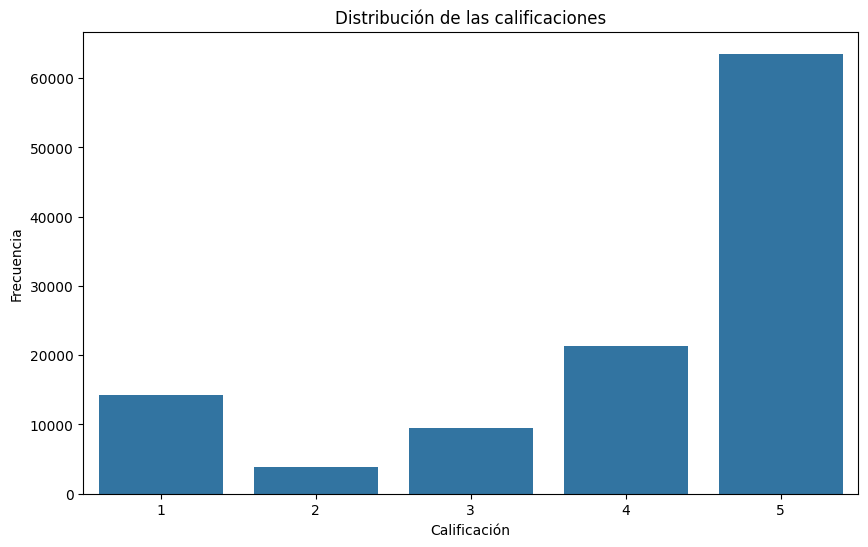

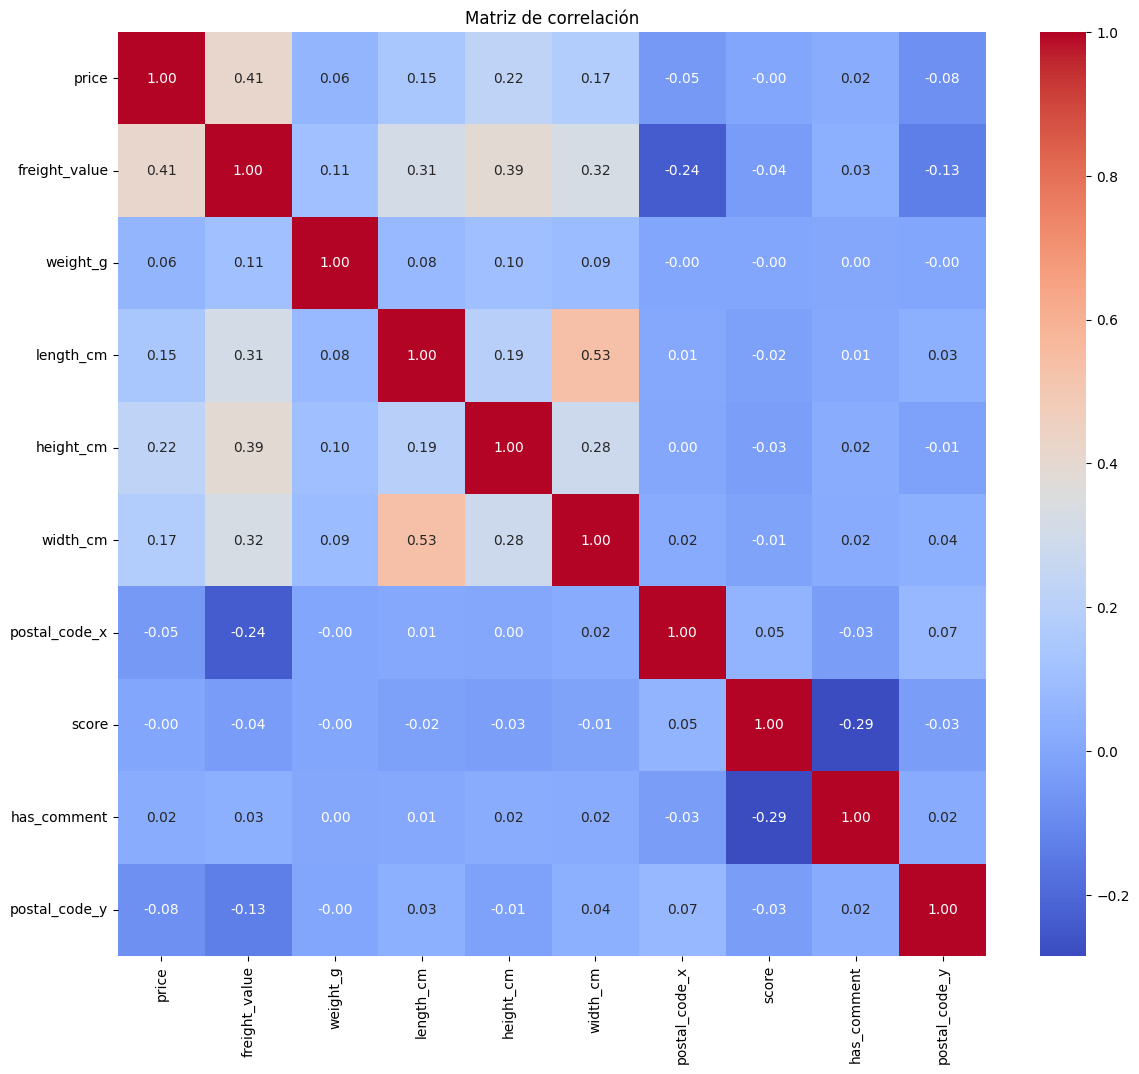

In [ ]:
# Descriptive statistics
print(final_merged.describe())

# Distribution of target variable (score)
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=final_merged)
plt.title('Distribución de las calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

# Select numeric columns
numeric_cols = final_merged.select_dtypes(include=[np.number]).columns

# Correlation matrix
corr_matrix = final_merged[numeric_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

In [ ]:
# Encode categorical variables
final_merged_encoded = pd.get_dummies(final_merged, columns=['status', 'category_name'], drop_first=True)

# Normalize numeric features
scaler = StandardScaler()
numeric_features = ['price', 'freight_value', 'weight_g', 'length_cm', 'height_cm', 'width_cm']
final_merged_encoded[numeric_features] = scaler.fit_transform(final_merged_encoded[numeric_features])

# Select features and target
features = final_merged_encoded.drop(columns=['order_id', 'customer_id', 'product_id', 'seller_id', 'purchase_timestamp',
                                              'approved_at', 'delivered_courier_date', 'delivered_customer_date',
                                              'estimated_delivery_date', 'review_id', 'review_creation_date',
                                              'review_answer_timestamp', 'customer_unique_id', 'postal_code_x',
                                              'postal_code_y', 'score'])
target = final_merged_encoded['score']

# Display first few rows of features and target
features.head(), target.head()

(  shipping_limit_date     price  freight_value  weight_g  length_cm  \
 0 2022-10-06 13:07:15 -0.496229      -0.713358 -0.077922  -0.690997   
 1 2022-08-21 22:05:16 -0.496229      -0.772922 -0.077922  -0.690997   
 2 2022-08-08 20:37:31 -0.496229      -0.772922 -0.077922  -0.690997   
 3 2022-10-31 03:14:11 -0.496229      -0.372449 -0.077922  -0.690997   
 4 2022-08-16 15:50:09 -0.244187      -0.772288 -0.090275  -0.629032   
 
    height_cm  width_cm  has_comment  status_canceled  status_delivered  ...  \
 0  -0.638268 -0.854280            1            False              True  ...   
 1  -0.638268 -0.854280            1            False              True  ...   
 2  -0.638268 -0.854280            1            False              True  ...   
 3  -0.638268 -0.854280            0            False              True  ...   
 4  -0.489422 -0.683436            1            False              True  ...   
 
    category_name_signaling_and_security  category_name_small_appliances  \
 0      

In [ ]:
# Drop 'shipping_limit_date' from features
features = features.drop(columns=['shipping_limit_date'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

Hyperparameter Tuning Progress: 100%|██████████| 108/108 [06:11<00:00,  3.44s/it]


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best Mean Squared Error: 1.5713936951017855
Mean Squared Error: 1.5713936951017855


<ipython-input-11-af3ea8e34d23>:58: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


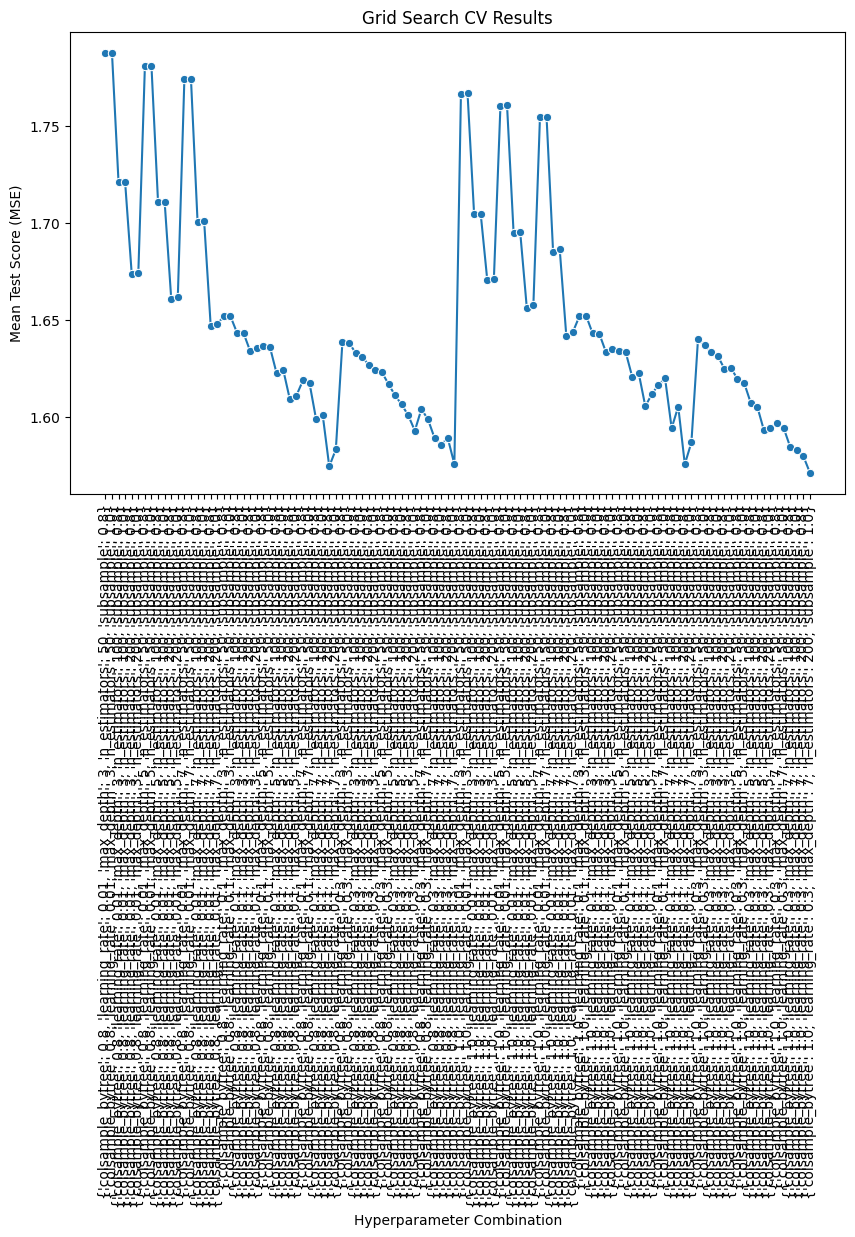

In [ ]:
# Setup parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Convert parameter grid to list of parameter combinations
param_combinations = list(ParameterGrid(param_grid))

# Initialize variables to store results
best_params = None
best_score = float('inf')
results = []

# Iterate over parameter combinations with tqdm for progress visualization
for params in tqdm(param_combinations, desc="Hyperparameter Tuning Progress"):
    xgb_regressor = XGBRegressor(**params, random_state=42)
    xgb_regressor.fit(X_train, y_train)
    y_pred = xgb_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Save the results
    results.append((params, mse))

    # Update best parameters if current score is better
    if mse < best_score:
        best_score = mse
        best_params = params

print(f"Best parameters: {best_params}")
print(f"Best Mean Squared Error: {best_score}")

# Train final model with best parameters
best_xgb_regressor = XGBRegressor(**best_params, random_state=42)
best_xgb_regressor.fit(X_train, y_train)

# Predict on test set
y_pred = best_xgb_regressor.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Visualize GridSearchCV results
results_df = pd.DataFrame(results, columns=['params', 'mse'])
results_df = results_df.sort_values(by='mse')

# Plot mean test scores for each hyperparameter combination
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x=results_df.index, y='mse', marker='o')
plt.xticks(results_df.index, results_df['params'], rotation=90)
plt.title('Grid Search CV Results')
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score (MSE)')
plt.tight_layout()
plt.show()

In [ ]:
r2 = r2_score(y_test, y_pred)
print(r2)

0.18710010777950503
